In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

## Чтение файлов и приведение столбцов к snake_case

In [6]:
events = pd.read_csv('events_ab.csv', sep=',', encoding='utf-8')
events.columns = events.columns.str.lower().str.replace(' ', '_')

In [7]:
users = pd.read_csv('users_ab.csv', sep=',', encoding='utf-8')
events.columns = events.columns.str.lower().str.replace(' ', '_')

In [8]:
visits = pd.read_csv('visits_daily.csv', sep=',', encoding='utf-8')
visits.columns = visits.columns.str.lower().str.replace(' ', '_').str.replace('дата_события', 'event_date')

## Проверка типов данных

In [9]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334308 entries, 0 to 334307
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           334308 non-null  object 
 1   event_dt          334308 non-null  object 
 2   event_type        334308 non-null  object 
 3   screen_name       129535 non-null  object 
 4   button_name       77495 non-null   object 
 5   amount            51855 non-null   float64
 6   transaction_type  51909 non-null   object 
dtypes: float64(1), object(6)
memory usage: 17.9+ MB


In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   event_date    181 non-null    object
 1   visits        181 non-null    int64 
 2   holiday_flag  181 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ KB


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   5025 non-null   object 
 1   group     5025 non-null   object 
 2   age       4875 non-null   float64
 3   city      4773 non-null   object 
 4   device    5017 non-null   object 
 5   reg_date  5025 non-null   object 
dtypes: float64(1), object(5)
memory usage: 235.7+ KB


In [12]:
users['reg_date'] = pd.to_datetime(users['reg_date'], errors='coerce')
users['group'] = users['group'].astype('category')
users['city'] = users['city'].astype('category')
users['device'] = users['device'].astype('category')

In [13]:
visits['event_date'] = pd.to_datetime(visits['event_date'], errors='coerce')
visits['holiday_flag'] = visits['holiday_flag'].astype('category')

In [14]:
events['event_dt'] = pd.to_datetime(events['event_dt'], errors='coerce')
events['event_type'] = events['event_type'].astype('category')
events['screen_name'] = events['screen_name'].astype('category')
events['button_name'] = events['button_name'].astype('category')
events['transaction_type'] = events['transaction_type'].astype('category')

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   5025 non-null   object        
 1   group     5025 non-null   category      
 2   age       4875 non-null   float64       
 3   city      4773 non-null   category      
 4   device    5017 non-null   category      
 5   reg_date  5025 non-null   datetime64[ns]
dtypes: category(3), datetime64[ns](1), float64(1), object(1)
memory usage: 133.4+ KB


In [16]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event_date    181 non-null    datetime64[ns]
 1   visits        181 non-null    int64         
 2   holiday_flag  181 non-null    category      
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 3.3 KB


In [17]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334308 entries, 0 to 334307
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           334308 non-null  object        
 1   event_dt          334308 non-null  datetime64[ns]
 2   event_type        334308 non-null  category      
 3   screen_name       129535 non-null  category      
 4   button_name       77495 non-null   category      
 5   amount            51855 non-null   float64       
 6   transaction_type  51909 non-null   category      
dtypes: category(4), datetime64[ns](1), float64(1), object(1)
memory usage: 8.9+ MB


## Проверка на пропуски и заполнение

In [18]:
def missing(df, df_name):
    count = len(df)
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / count) * 100
    missing_df = pd.DataFrame({
        'количество_пропусков': missing_data,
        'процент_пропусков': round(missing_percent, 2)
    })
    print(df_name, '\n')
    print(f'Всего строк: {count}\n')
    print(missing_df, '\n')
    print('Столбцы с пропущенными значениями:\n')
    print(missing_df[missing_df['количество_пропусков']>0])

In [19]:
missing_users = missing(users, 'users')

users 

Всего строк: 5025

          количество_пропусков  процент_пропусков
user_id                      0               0.00
group                        0               0.00
age                        150               2.99
city                       252               5.01
device                       8               0.16
reg_date                     0               0.00 

Столбцы с пропущенными значениями:

        количество_пропусков  процент_пропусков
age                      150               2.99
city                     252               5.01
device                     8               0.16


Пропуски в возрасте можно заполнить медианой, посмотрим медианы по группам и запоним пропуски

In [20]:
median_age = users.groupby('group', observed=False)['age'].median()
median_age

group
A    35.0
B    35.0
Name: age, dtype: float64

In [21]:
users['age'] = users['age'].fillna(users['group'].map(median_age))

In [22]:
users['city'] = users['city'].cat.add_categories(['unknown'])
users['city'] = users['city'].fillna('unknown')

Пропусков в столбце device мало, мене 1%, но, если удалить строки с пропусками в таблице users, то автоматически удалится
информация и из таблицы events, посмотрим сколько данных мы потеряем.

In [23]:
list(users[users['device'].isna()]['user_id'])

['user_00013',
 'user_00132',
 'user_00192',
 'user_00501',
 'user_00910',
 'user_00912',
 'user_00928',
 'user_01267']

In [24]:
len(events[events['user_id'].isin (['user_00013',
 'user_00132',
 'user_00192',
 'user_00501',
 'user_00910',
 'user_00912',
 'user_00928',
 'user_01267'])])

491

In [25]:
len(events[events['user_id'].isin (['user_00013',
 'user_00132',
 'user_00192',
 'user_00501',
 'user_00910',
 'user_00912',
 'user_00928',
 'user_01267'])]) / len(events)

0.0014687055051030786

In [26]:
new_event = events[events['user_id'].isin (['user_00013',
 'user_00132',
 'user_00192',
 'user_00501',
 'user_00910',
 'user_00912',
 'user_00928',
 'user_01267'])]

In [27]:
len(new_event[new_event['transaction_type'].notnull()]) / len(events[events['transaction_type'].notnull()])

0.0014833651197287562

In [28]:
(new_event['amount'].sum()) / (events['amount'].sum())

0.0014586155964132397

Мы теряем очень маленький процент информации, менее 0.01, так же в столбце device содержатся категориальные данные, заполнив которые мы можем исказить информацию, поскольку их сложно восстановить, поэтому можно удалить строки с пропусками в столбце device.

In [29]:
users = users.dropna()

In [30]:
missing(users, 'users')

users 

Всего строк: 5017

          количество_пропусков  процент_пропусков
user_id                      0                0.0
group                        0                0.0
age                          0                0.0
city                         0                0.0
device                       0                0.0
reg_date                     0                0.0 

Столбцы с пропущенными значениями:

Empty DataFrame
Columns: [количество_пропусков, процент_пропусков]
Index: []


In [31]:
missing_visits = missing(visits, 'visits')

visits 

Всего строк: 181

              количество_пропусков  процент_пропусков
event_date                       0                0.0
visits                           0                0.0
holiday_flag                     0                0.0 

Столбцы с пропущенными значениями:

Empty DataFrame
Columns: [количество_пропусков, процент_пропусков]
Index: []


В таблице visits пропусков нет

In [32]:
missing_events = missing(events, 'events')

events 

Всего строк: 334308

                  количество_пропусков  процент_пропусков
user_id                              0               0.00
event_dt                             0               0.00
event_type                           0               0.00
screen_name                     204773              61.25
button_name                     256813              76.82
amount                          282453              84.49
transaction_type                282399              84.47 

Столбцы с пропущенными значениями:

                  количество_пропусков  процент_пропусков
screen_name                     204773              61.25
button_name                     256813              76.82
amount                          282453              84.49
transaction_type                282399              84.47


Перейдем к таблице events, для нее функцию missing будет некорректно использовать, поскольку столбец screen_name может быть заполнен только, когда в столбце event_dt стоит значение screen_view, столбец button_name может быть заполнет только, когда в столбце event_dt стоит значение button_click и т.д.

In [33]:
print(f'Пропуски в screen_name: {round(len(events[(events['event_type'] == 'screen_view') &
    (events['screen_name'].isna())]) / len(events), 4)}')

print(f'Пропуски в button_name: {round(len(events[(events['event_type'] == 'button_click') &
    (events['button_name'].isna())]) / len(events), 4)}')

print(f'Пропуски в transaction_type: {round(len(events[(events['event_type'] == 'transaction') &
    (events['transaction_type'].isna())]) / len(events), 4)}')

print(f'Пропуски в amount: {round(len(events[(events['event_type'] == 'transaction') &
    (events['amount'].isna())]) / len(events), 4)}')

Пропуски в screen_name: 0.0079
Пропуски в button_name: 0.0046
Пропуски в transaction_type: 0.0031
Пропуски в amount: 0.0032


Всего пропущенных значений около 2%, screen_name, button_name, transaction_type это категориальные данные, если их заполнять, то это может привести к искажению данных, поэтому их стоит удалить, т.к. процент пропусков небольшой.

In [34]:
events = events.drop(
    events[(events['event_type'] == 'screen_view') & (events['screen_name'].isna())].index
)

In [35]:
events = events.drop(
    events[(events['event_type'] == 'button_click') & (events['button_name'].isna())].index
)

In [36]:
events = events.drop(
    events[(events['event_type'] == 'transaction') & (events['transaction_type'].isna())].index
)

Оставшиеся пропуски в этих трех столбцах обоснованы, но можно их заменить отдельной категорией для дальнейшего удобства в исследовании.

In [37]:
events['screen_name'] = events['screen_name'].cat.add_categories('no_screen_view')

In [38]:
events['screen_name'] = events['screen_name'].fillna('no_screen_view')

In [39]:
events['button_name'] = events['button_name'].cat.add_categories('no_button_click')

In [40]:
events['button_name'] = events['button_name'].fillna('no_button_click')

In [41]:
events['transaction_type'] = events['transaction_type'].cat.add_categories('no_transaction')

In [42]:
events['transaction_type'] = events['transaction_type'].fillna('no_transaction')

Доля пропусков в amount очень маленькая, поэтому, чтобы не икажать данные удалим столбцы с пропусками.

In [43]:
events = events.drop(
    events[(events['event_type'] == 'transaction') & (events['amount'].isna())].index
)

Оставшиеся пропуски являются обоснованными, т.к. транзакции не всегда совершались, заменить их 0 будет некорректно, поскольку это может исказить статистические значения, поэтому оставим их.

In [44]:
missing(events, 'event')

event 

Всего строк: 328034

                  количество_пропусков  процент_пропусков
user_id                              0                0.0
event_dt                             0                0.0
event_type                           0                0.0
screen_name                          0                0.0
button_name                          0                0.0
amount                          277184               84.5
transaction_type                     0                0.0 

Столбцы с пропущенными значениями:

        количество_пропусков  процент_пропусков
amount                277184               84.5


# Поиск и обработка дубликатов

In [45]:
def dup(df, df_name):
    duplicate = df.duplicated().sum()
    print(df_name.upper())
    return print('Количество дубликатов: ', duplicate)

In [46]:
dup(users, 'users')
dup(visits, 'visits')
dup(events, 'events')

USERS
Количество дубликатов:  0
VISITS
Количество дубликатов:  0
EVENTS
Количество дубликатов:  1227


In [47]:
events.drop_duplicates(inplace=True)

In [48]:
dup(events, 'events')

EVENTS
Количество дубликатов:  0


Из таблиц удалены все явные дубликаты, теперь проверим таблицы на неявные дубликаты. Неявные дубликаты могут быть тольк в категориальных данных, поэтому категориальные данные во всех таблицах.

In [49]:
list((visits['holiday_flag'].unique()))

[1, 0]

В таблице visits нет неявных дубликатов.

In [50]:
list((users['group'].unique()))

['A', 'B']

In [51]:
list((users['city'].unique()))

['Другой',
 'Москва',
 'Новосибирск',
 'Санкт-Петербург',
 'unknown',
 'Екатеринбург',
 'Сыктывкар',
 'Орел']

In [52]:
list((users['device'].unique()))

['Android', 'iOS', 'ios', 'And+E1782roid', 'IOS', 'AndroiD', 'ANDROID']

In [53]:
users.loc[users['device'].isin(['Android', 'And+E1782roid', 'AndroiD', 'ANDROID']), 'device'] = 'Android'
users.loc[users['device'].isin(['iOS', 'ios', 'IOS']), 'device'] = 'ios'

In [54]:
dup(users, 'users')

USERS
Количество дубликатов:  0


В таблице users не было неявных дубликатов.

In [55]:
list((events['event_type'].unique()))

['login', 'screen_view', 'button_click', 'transaction', 'logout']

In [56]:
list((events['screen_name'].unique()))

['no_screen_view',
 'transfers',
 'main',
 'payments',
 'cards',
 'profile',
 'settings']

In [57]:
list((events['button_name'].unique()))

['no_button_click', 'transfer', 'payment', 'support', 'card_details']

In [58]:
list((events['transaction_type'].unique()))

['no_transaction', 'transfer', 'payment']

В таблице events нет неявных дубликатов.

# Анализ и обработка выбросов

Проверим данные в таблице users на корректоность.

In [59]:
print('Описательная статистика для возраста:\n')
print(users['age'].describe())
no_correct_age = len(users[(users['age'] < 14) | (users['age'] > 100)])
print(f'Значений с неорректыным возрастом: {no_correct_age}')

Описательная статистика для возраста:

count    5017.000000
mean       35.133347
std        10.979045
min        10.000000
25%        28.000000
50%        35.000000
75%        41.000000
max       120.000000
Name: age, dtype: float64
Значений с неорректыным возрастом: 37


In [60]:
users = users.drop(
    users[(users['age'] < 14) | (users['age'] > 100)].index
)

In [61]:
print(f'Минимальная дата регистрации: {min(users['reg_date'])}')
print(f'Максимальная дата регистрации: {max(users['reg_date'])}')

Минимальная дата регистрации: 2022-11-18 00:00:00
Максимальная дата регистрации: 2025-11-17 00:00:00


Выбросов в столбце reg_date нет, отсутсвуют значения из будущего и слишком давние даты регистрации.

Проверим данные в таблице visits на наличие некорректных значений.

In [62]:
print(f'Событий, которые произошли раньше минимальной даты регистрации: {min(visits['event_date']) < min(users['reg_date'])}')
print(f'Минимальная дата события: {min(visits['event_date'])}')
print(f'Максимальная дата события: {max(visits['event_date'])}')

Событий, которые произошли раньше минимальной даты регистрации: False
Минимальная дата события: 2025-05-21 00:00:00
Максимальная дата события: 2025-11-17 00:00:00


In [63]:
print(f'Количество отрицательных песещений: {len(visits[visits['visits'] < 0])}')

Количество отрицательных песещений: 0


В visits нет некорректных значений.

Проверим таблицу events.

In [64]:
print('Проверка на корректность дат:\n')
print(f'Максимальная дата события: {max(events['event_dt'])}')
print(f'Минимальная дата события: {min(events['event_dt'])}')

Проверка на корректность дат:

Максимальная дата события: 2025-11-10 01:47:06.488811
Минимальная дата события: 2025-10-27 01:26:06.488811


In [113]:
first_events = events.groupby('user_id').first().reset_index()
no_correct_start = first_events[first_events['event_type'] == 'logout']
print(f'Нарушений в логике событий: {len(no_correct_start)}')

Нарушений в логике событий: 0


В events нет некорректных значений.

# Работа с категориальными признаками

In [66]:
print('Распределение пользователей по городам:\n')
group_city = round(users.groupby('city', observed=True)['user_id'].count() / len(users), 4) * 100
print(group_city)

Распределение пользователей по городам:

city
Другой             15.04
Екатеринбург       13.33
Москва             28.49
Новосибирск        15.30
Орел                0.04
Санкт-Петербург    22.75
Сыктывкар           0.02
unknown             5.02
Name: user_id, dtype: float64


Количество пользователей из Орла и Сыктывкара очень мало(менее 1%), поэтому их можно объединить в отдельную категорию.

In [67]:
users['city'] = users['city'].apply(lambda x: 'Другой' if x in ['Сыктывкар', 'Орел'] else x)

In [68]:
print('Распределение пользователей по городам:\n')
group_city = round(users.groupby('city', observed=True)['user_id'].count() / len(users), 4) * 100
print(group_city)

Распределение пользователей по городам:

city
unknown             5.02
Другой             15.10
Екатеринбург       13.33
Москва             28.49
Новосибирск        15.30
Санкт-Петербург    22.75
Name: user_id, dtype: float64


# Аналитический и графический анализ

Распределение числовых признаков:



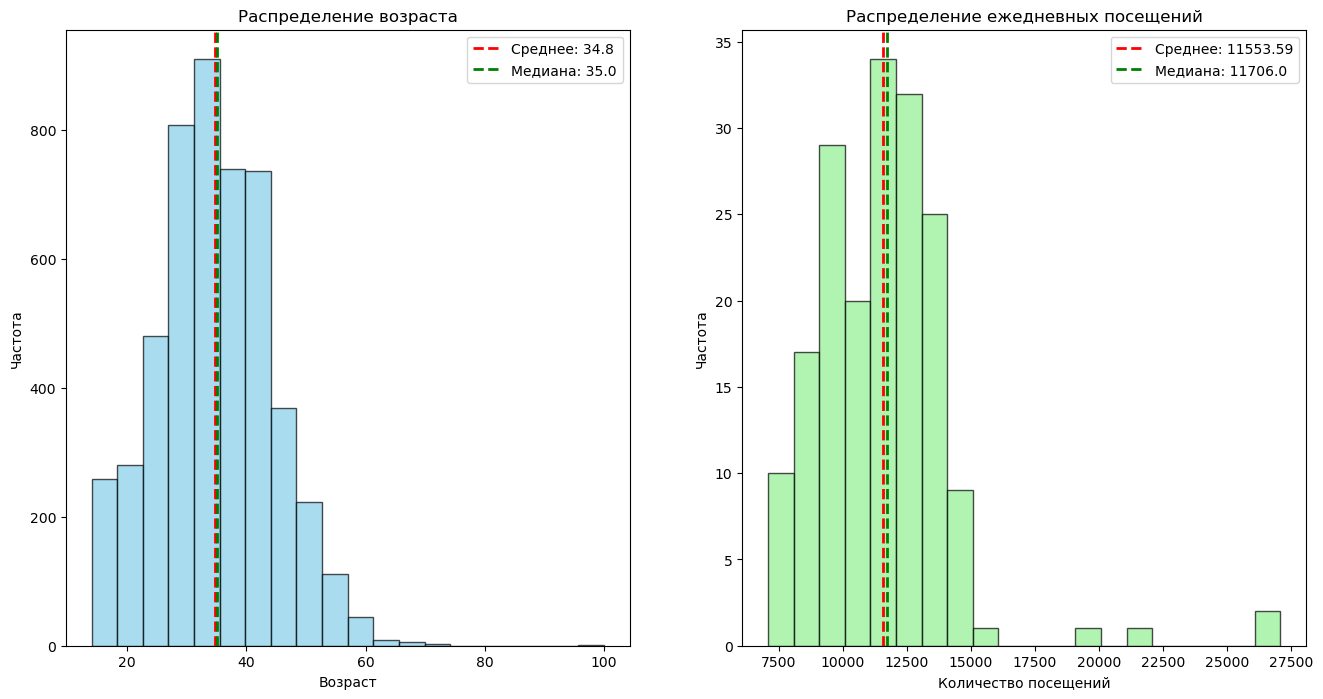

In [69]:
print("Распределение числовых признаков:\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

mean_age = users['age'].mean()
median_age = users['age'].median()

axes[0].hist(users['age'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_title('Распределение возраста')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Частота')
axes[0].axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_age:.1f}')
axes[0].axvline(median_age, color='green', linestyle='--', linewidth=2, label=f'Медиана: {median_age:.1f}')
axes[0].legend()

mean_visits = visits['visits'].mean()
median_visits = visits['visits'].median()

axes[1].hist(visits['visits'], bins=20, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_title('Распределение ежедневных посещений')
axes[1].set_xlabel('Количество посещений')
axes[1].set_ylabel('Частота')
axes[1].axvline(mean_visits, color='red', linestyle='--', linewidth=2, label=f'Среднее: {round(mean_visits, 2)}')
axes[1].axvline(median_visits, color='green', linestyle='--', linewidth=2, label=f'Медиана: {round(median_visits, 2)}')
axes[1].legend()

plt.show()

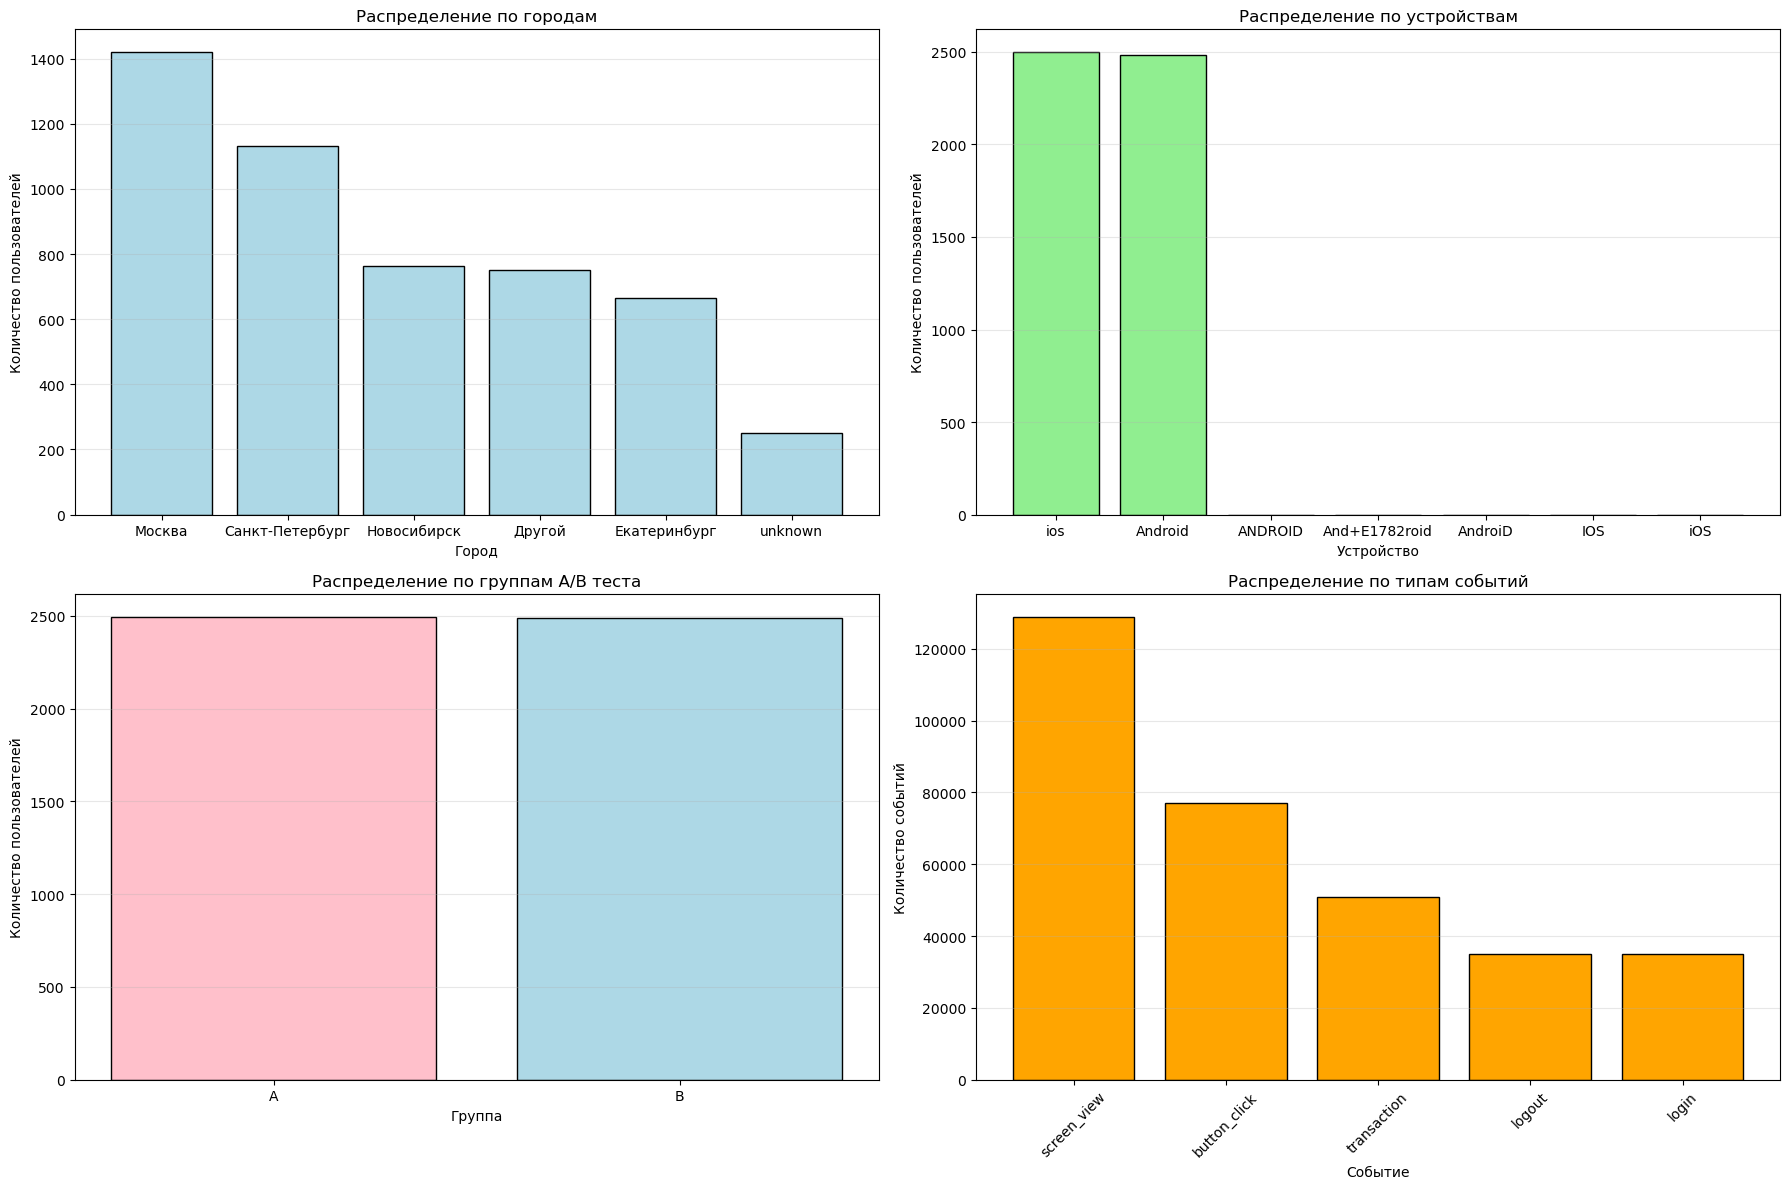

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

city_counts = users['city'].value_counts() 
axes[0, 0].bar(city_counts.index, city_counts.values, color='lightblue', edgecolor='black')
axes[0, 0].set_title('Распределение по городам', fontsize=12)
axes[0, 0].set_xlabel('Город', fontsize=10)
axes[0, 0].set_ylabel('Количество пользователей', fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

device_counts = users['device'].value_counts()
axes[0, 1].bar(device_counts.index, device_counts.values, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Распределение по устройствам', fontsize=12)
axes[0, 1].set_xlabel('Устройство', fontsize=10)
axes[0, 1].set_ylabel('Количество пользователей', fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)

group_counts = users['group'].value_counts()
axes[1, 0].bar(group_counts.index, group_counts.values, color=['pink', 'lightblue'], edgecolor='black')
axes[1, 0].set_title('Распределение по группам A/B теста', fontsize=12)
axes[1, 0].set_xlabel('Группа', fontsize=10)
axes[1, 0].set_ylabel('Количество пользователей', fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

event_counts = events['event_type'].value_counts()
axes[1, 1].bar(event_counts.index, event_counts.values, color='orange', edgecolor='black')
axes[1, 1].set_title('Распределение по типам событий', fontsize=12)
axes[1, 1].set_xlabel('Событие', fontsize=10)
axes[1, 1].set_ylabel('Количество событий', fontsize=10)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

<h1>Проведение расчетов и исследований</h1>

In [71]:
events.head()

,user_id,event_dt,event_type,screen_name,button_name,amount,transaction_type
0,user_00000,2025-11-07 18:08:06.488811,login,no_screen_view,no_button_click,NaN,no_transaction
1,user_00000,2025-11-07 18:08:53.488811,screen_view,transfers,no_button_click,NaN,no_transaction
2,user_00000,2025-11-07 18:09:38.488811,button_click,no_screen_view,transfer,NaN,no_transaction
3,user_00000,2025-11-07 18:10:13.488811,screen_view,main,no_button_click,NaN,no_transaction
4,user_00000,2025-11-07 18:10:32.488811,button_click,no_screen_view,payment,NaN,no_transaction


In [72]:
# Функция для выделения сессий
def identify_sessions(user_events):
    sessions = []
    current_session = []
    session_start = None
    
    for _, event in user_events.iterrows():
        if event['event_type'] == 'login':
            if current_session:  # Если есть незавершенная сессия
                sessions.append(current_session)
            current_session = [event]
            session_start = event['event_dt']
        elif event['event_type'] == 'logout' and current_session:
            current_session.append(event)
            sessions.append(current_session)
            current_session = []
        else:
            current_session.append(event)
    
    if current_session:
        sessions.append(current_session)
    return sessions

Размечаем все сессии

In [75]:
all_sessions = []
for user_id in events['user_id'].unique():
    user_events = events[events['user_id'] == user_id]
    user_sessions = identify_sessions(user_events)
    
    for session in user_sessions:
        if session:  # Проверяем, что сессия не пустая
            session_df = pd.DataFrame(session)
            session_info = {
                'user_id': user_id,
                'session_start': session_df['event_dt'].iloc[0],
                'session_end': session_df['event_dt'].iloc[-1],
                'events_count': len(session_df),
                'has_transaction': 'transaction' in session_df['event_type'].values,
                'session_duration': (session_df['event_dt'].iloc[-1] - session_df['event_dt'].iloc[0]).total_seconds() / 60  # в минутах
            }
            all_sessions.append(session_info)

# Делаем датафрейм из всех сессий
sessions_df = pd.DataFrame(all_sessions)
print(f"Найдено {len(sessions_df)} сессий")

Найдено 35077 сессий


Считаем метрики для каждого пользователя

In [77]:
user_metrics = []
for user_id in users['user_id'].unique():
    user_session_data = sessions_df[sessions_df['user_id'] == user_id]
    
    sessions_count = len(user_session_data)
    avg_events = user_session_data['events_count'].mean()
    conversion = user_session_data['has_transaction'].mean()
    avg_duration = user_session_data['session_duration'].mean()
    
    user_metrics.append({
        'user_id': user_id,
        'sessions_count': sessions_count,
        'avg_events_per_session': avg_events,
        'conversion_rate': conversion,
        'avg_session_duration_min': avg_duration
    })

user_metrics_df = pd.DataFrame(user_metrics)

# Добавляем информацию о группе из users
user_metrics_df = user_metrics_df.merge(users[['user_id', 'group']], on='user_id', how='left')

Сводная статистика по группам

In [78]:
print("\n=== Статистика по группам ===")
group_stats = user_metrics_df.groupby('group').agg({
    'sessions_count': 'mean',
    'avg_events_per_session': 'mean',
    'conversion_rate': 'mean',
    'avg_session_duration_min': 'mean',
    'user_id': 'count'
}).round(3)

group_stats.columns = ['avg_sessions', 'avg_events', 'avg_conversion', 'avg_duration_min', 'user_count']
print(group_stats)


=== Статистика по группам ===
       avg_sessions  avg_events  avg_conversion  avg_duration_min  user_count
group                                                                        
A             6.018       9.255           0.754             4.855        2492
B             7.936       9.294           0.762             9.385        2488


C:\Users\Home\AppData\Local\Temp\ipykernel_9264\554688799.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = user_metrics_df.groupby('group').agg({


Считаем транзакции для каждого пользователя

In [79]:
user_transactions = events[events['event_type'] == 'transaction'].groupby('user_id').size().reset_index(name='transaction_count')

# Объединяем все данные
user_data = users.merge(user_transactions, on='user_id', how='left').fillna({'transaction_count': 0})
user_data = user_data.merge(user_metrics_df[['user_id', 'sessions_count', 'conversion_rate']], on='user_id')

# Среднее количество транзакций по группам и устройствам
print("\n1. Среднее количество транзакций на пользователя:")
pivot_transactions = pd.pivot_table(
    user_data,
    values='transaction_count',
    index='device',
    columns='group',
    aggfunc='mean'
).round(2)
print(pivot_transactions)

# Пользователи с транзакциями по городам и группам
print("\n2. Количество пользователей с хотя бы одной транзакцией:")
transaction_users = events[events['event_type'] == 'transaction']['user_id'].unique()
user_data['has_transaction'] = user_data['user_id'].isin(transaction_users).astype(int)

# Только те, у кого есть транзакции
users_with_transactions = user_data[user_data['has_transaction'] == 1]

pivot_active_users = pd.pivot_table(
    users_with_transactions,
    values='user_id',
    index='city',
    columns='group',
    aggfunc='count',
    fill_value=0
)
print(pivot_active_users)

# Сколько всего скрин вью событий
screen_view_count = events[events['event_type'] == 'screen_view'].shape[0]
print(f"\n3. Всего событий screen_view: {screen_view_count}")


1. Среднее количество транзакций на пользователя:


C:\Users\Home\AppData\Local\Temp\ipykernel_9264\600469409.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_transactions = pd.pivot_table(


group       A      B
device              
Android  8.84  11.56
ios      8.51  11.54

2. Количество пользователей с хотя бы одной транзакцией:
group              A    B
city                     
unknown          129  117
Другой           380  363
Екатеринбург     331  326
Москва           713  694
Новосибирск      364  391
Санкт-Петербург  549  577

3. Всего событий screen_view: 128721


C:\Users\Home\AppData\Local\Temp\ipykernel_9264\600469409.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_active_users = pd.pivot_table(


Проверка адекватности данных

In [108]:
print("\nСтатистика длительности сессий (минуты):")
print(sessions_df['session_duration'].describe().round(2))

# Сравниваем с нормами для банковских приложений
median_duration = sessions_df['session_duration'].median()
print(f"\nМедианная длительность сессии: {median_duration:.2f} мин.")

if 2 <= median_duration <= 6:
    print("Нормально для банковского приложения")
elif median_duration < 1:
    print("Слишком короткие сессии")
else:
    print("Слишком длинные сессии")

# Проверяем аномально длинные сессии
long_sessions = sessions_df[sessions_df['session_duration'] > 15].shape[0]
print(f"Сессий длиннее 15 минут: {long_sessions}")


Статистика длительности сессий (минуты):
count    35077.00
mean         7.48
std          7.30
min          0.00
25%          2.04
50%          5.06
75%         10.48
max         30.00
Name: session_duration, dtype: float64

Медианная длительность сессии: 5.06 мин.
Нормально для банковского приложения
Сессий длиннее 15 минут: 5108


Сохранение результатов

In [81]:
user_metrics_df.to_csv('user_metrics.csv', index=False)
print("Сохранено: user_metrics.csv")

sessions_df.to_csv('sessions_data.csv', index=False)
print("Сохранено: sessions_data.csv")

group_stats.to_csv('group_statistics.csv')
print("Сохранено: group_statistics.csv")

Сохранено: user_metrics.csv
Сохранено: sessions_data.csv
Сохранено: group_statistics.csv


ПРОВЕРКА ГИПОТЕЗ

In [82]:
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

print("Загрузка данных для проверки гипотез...")
user_metrics = pd.read_csv('user_metrics.csv')

# Разделение данных на группы A и B
group_a = user_metrics[user_metrics['group'] == 'A']
group_b = user_metrics[user_metrics['group'] == 'B']

print(f"Размер группы A: {len(group_a)} пользователей")
print(f"Размер группы B: {len(group_b)} пользователей")

Загрузка данных для проверки гипотез...
Размер группы A: 2492 пользователей
Размер группы B: 2488 пользователей


Функции

In [83]:
# Проверка нормальности распределения данных (ШАПИРО)
def check_normality(data_a, data_b, metric_name):
    _, p_value_a = stats.shapiro(data_a.sample(min(5000, len(data_a))))  # Ограничиваем выборку для теста
    _, p_value_b = stats.shapiro(data_b.sample(min(5000, len(data_b))))
    
    print(f"\nПроверка нормальности для '{metric_name}':")
    print(f"  Группа A: p-value = {p_value_a:.4f} {'(нормальное)' if p_value_a > 0.05 else '(не нормальное)'}")
    print(f"  Группа B: p-value = {p_value_b:.4f} {'(нормальное)' if p_value_b > 0.05 else '(не нормальное)'}")
    
    return p_value_a > 0.05 and p_value_b > 0.05

# Функция для расчета доверительных интервалов для средних значений
def calculate_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    ci = stats.t.interval(confidence, len(data) - 1, loc=mean, scale=sem)
    return mean, ci

# Функция для визуализации результатов теста
def plot_comparison(data_a, data_b, metric_name, unit="", show_distribution=True):
    fig, axes = plt.subplots(1, 2 if show_distribution else 1, 
                           figsize=(14, 6) if show_distribution else (7, 6))
    
    if show_distribution:
        # Боксплот
        ax1 = axes[0]
        data_to_plot = [data_a.dropna(), data_b.dropna()]
        bp = ax1.boxplot(data_to_plot, labels=['Группа A', 'Группа B'], 
                        patch_artist=True)
        
        # Раскрашиваем боксы
        colors = ['lightblue', 'lightcoral']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        ax1.set_title(f'Распределение {metric_name}', fontsize=14, fontweight='bold')
        ax1.set_ylabel(f'{metric_name} ({unit})' if unit else metric_name)
        ax1.grid(True, alpha=0.3)
        ax2 = axes[1]
        
    # Барплот со средними значениями и доверительными интервалами
    else:
        ax2 = axes
    
    # Рассчитываем средние и доверительные интервалы
    mean_a, ci_a = calculate_confidence_interval(data_a)
    mean_b, ci_b = calculate_confidence_interval(data_b)
    
    groups = ['Группа A', 'Группа B']
    means = [mean_a, mean_b]
    ci_lower = [mean_a - ci_a[0], mean_b - ci_b[0]]
    ci_upper = [ci_a[1] - mean_a, ci_b[1] - mean_b]
    
    bars = ax2.bar(groups, means, yerr=[ci_lower, ci_upper], 
                   capsize=10, color=['lightblue', 'lightcoral'], 
                   edgecolor='black', linewidth=1.5)
    
    # Добавляем значения на столбцы
    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{mean_val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_title(f'Сравнение средних значений {metric_name}', fontsize=14, fontweight='bold')
    ax2.set_ylabel(f'Среднее значение ({unit})' if unit else 'Среднее значение')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return mean_a, mean_b, ci_a, ci_b

ПРОВЕРКА ГИПОТЕЗ

Гипотеза 1: Конверсия в транзакцию в группе B ВЫШЕ, чем в группе A

C:\Users\Home\AppData\Local\Temp\ipykernel_9264\4123727450.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats2 = user_metrics_df.groupby('group').agg({
C:\Users\Home\AppData\Local\Temp\ipykernel_9264\4123727450.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  success_a = (group_stats2[0])
C:\Users\Home\AppData\Local\Temp\ipykernel_9264\4123727450.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  success_b = (

Группа A: 75.4% пользователей совершили транзакцию
Группа B: 76.2% пользователей совершили транзакцию

Z-тест для пропорций:
  Z-статистика: -0.7186
  p-value: 0.2362
  РЕЗУЛЬТАТ: p-value (0.2362) ≥ 0.05 → Различие НЕ статистически значимо
  ВЫВОД: Нет достаточных доказательств, что конверсия в группе B выше


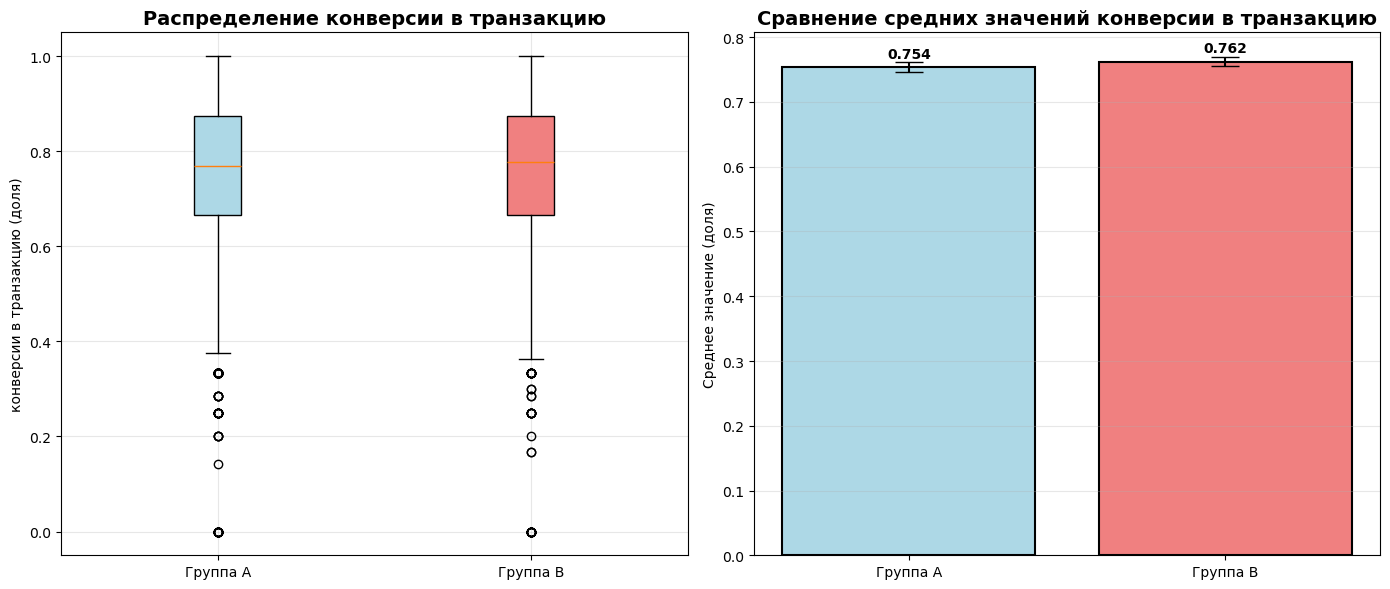


Доверительные интервалы (95%):
  Группа A: 0.7458 - 0.7613 (среднее: 0.7536)
  Группа B: 0.7555 - 0.7691 (среднее: 0.7623)


In [93]:
# Используем Z - тест
# Подсчитываем количество успехов (пользователей с хотя бы одной транзакцией в сессии)
data = group_stats["avg_conversion"]

group_stats2 = user_metrics_df.groupby('group').agg({
    'sessions_count': 'mean',
    'avg_events_per_session': 'mean',
    'conversion_rate': 'sum',
    'avg_session_duration_min': 'mean',
    'user_id': 'count'
}).round(3)["conversion_rate"]

success_a = (group_stats2[0])
success_b = (group_stats2[1])
n_a = len(group_a)
n_b = len(group_b)

print(f"Группа A: {data[0]*100:.1f}% пользователей совершили транзакцию")
print(f"Группа B: {data[1]*100:.1f}% пользователей совершили транзакцию")

# Z-тест для пропорций
count = np.array([success_a, success_b])
nobs = np.array([n_a, n_b])
z_stat, p_value = proportions_ztest(count, nobs, alternative='smaller')

print(f"\nZ-тест для пропорций:")
print(f"  Z-статистика: {z_stat:.4f}")
print(f"  p-value: {p_value:.4f}")

# Определяем статистическую значимость
alpha = 0.05
p_value_h1 = p_value
if p_value < alpha:
    print(f"  РЕЗУЛЬТАТ: p-value ({p_value:.4f}) < {alpha} => Различие СТАТИСТИЧЕСКИ ЗНАЧИМО")
    print(f"  ВЫВОД: Конверсия в группе B статистически значимо ВЫШЕ, чем в группе A")
else:
    print(f"  РЕЗУЛЬТАТ: p-value ({p_value:.4f}) ≥ {alpha} => Различие НЕ статистически значимо")
    print(f"  ВЫВОД: Нет достаточных доказательств, что конверсия в группе B выше")

# Визуализация
mean_a, mean_b, ci_a, ci_b = plot_comparison(
    group_a['conversion_rate'], 
    group_b['conversion_rate'], 
    'конверсии в транзакцию', 
    unit='доля', 
    show_distribution=True
)

print(f"\nДоверительные интервалы (95%):")
print(f"  Группа A: {ci_a[0]:.4f} - {ci_a[1]:.4f} (среднее: {mean_a:.4f})")
print(f"  Группа B: {ci_b[0]:.4f} - {ci_b[1]:.4f} (среднее: {mean_b:.4f})")

ГИПОТЕЗА 2: Среднее количество сессий на пользователя в группе B ОТЛИЧАЕТСЯ от группы A


Проверка нормальности для 'количество сессий':
  Группа A: p-value = 0.0000 (не нормальное)
  Группа B: p-value = 0.0000 (не нормальное)

Используем U-тест Манна-Уитни (данные НЕ распределены нормально)

U-тест Манна-Уитни:
  Статистика: 1874867.0000
  p-value: 0.0000
  РЕЗУЛЬТАТ: p-value (0.0000) < 0.05 → Различие СТАТИСТИЧЕСКИ ЗНАЧИМО
  ВЫВОД: Количество сессий в группе B статистически значимо БОЛЬШЕ, чем в группе A


C:\Users\Home\AppData\Local\Temp\ipykernel_9264\1946085054.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(data_to_plot, labels=['Группа A', 'Группа B'],


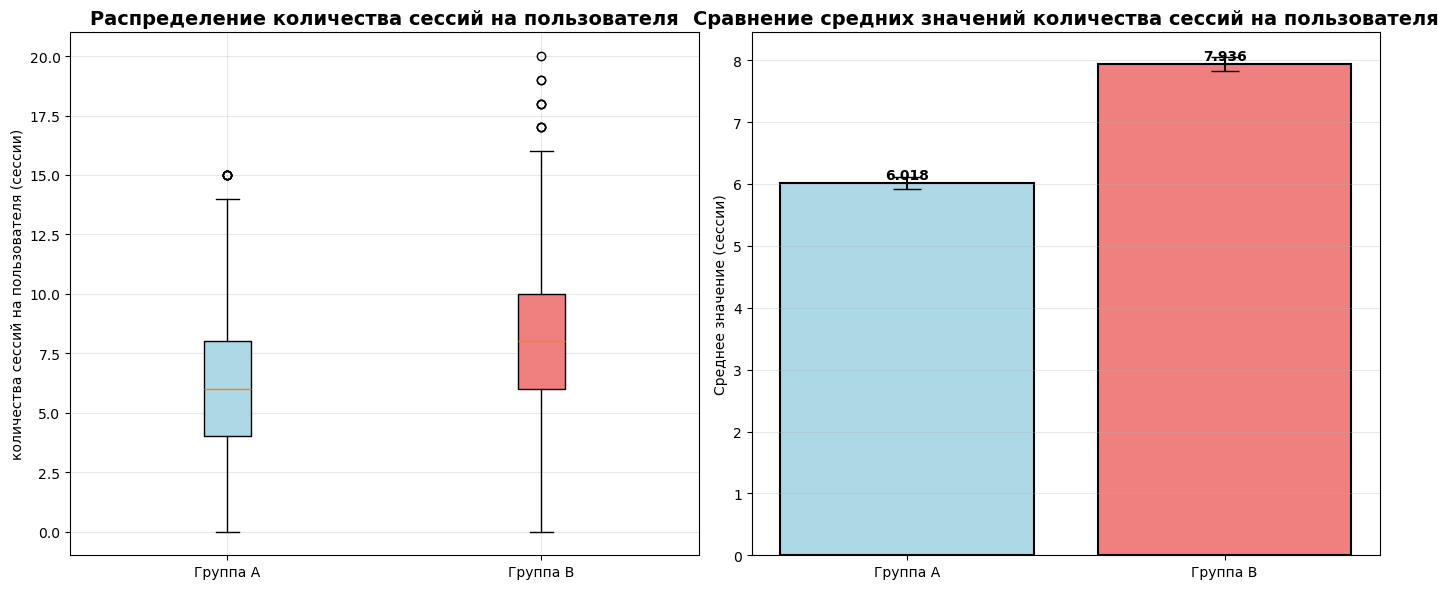


Доверительные интервалы (95%):
  Группа A: 5.92 - 6.12 (среднее: 6.02)
  Группа B: 7.83 - 8.05 (среднее: 7.94)


In [95]:
# Проверяем нормальность распределения
is_normal = check_normality(group_a['sessions_count'], group_b['sessions_count'], 'количество сессий')

# Выбираем тест в зависимости от нормальности распределения
if is_normal:
    print("\nИспользуем t-тест (данные распределены нормально)")
    t_stat, p_value = stats.ttest_ind(group_a['sessions_count'], 
                                       group_b['sessions_count'], 
                                       equal_var=False)  # Welch's t-test (не предполагаем равные дисперсии)
    test_name = "t-тест"
else:
    print("\nИспользуем U-тест Манна-Уитни (данные НЕ распределены нормально)")
    u_stat, p_value = stats.mannwhitneyu(group_a['sessions_count'], 
                                         group_b['sessions_count'], 
                                         alternative='two-sided')
    test_name = "U-тест Манна-Уитни"

print(f"\n{test_name}:")
print(f"  Статистика: {t_stat if is_normal else u_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
p_value_h2 = p_value
# Определяем статистическую значимость
if p_value < alpha:
    print(f"  РЕЗУЛЬТАТ: p-value ({p_value:.4f}) < {alpha} => Различие СТАТИСТИЧЕСКИ ЗНАЧИМО")
    
    # Определяем направление различия
    mean_a = group_a['sessions_count'].mean()
    mean_b = group_b['sessions_count'].mean()
    
    if mean_b > mean_a:
        print(f"  ВЫВОД: Количество сессий в группе B статистически значимо БОЛЬШЕ, чем в группе A")
    else:
        print(f"  ВЫВОД: Количество сессий в группе B статистически значимо МЕНЬШЕ, чем в группе A")
else:
    print(f"  РЕЗУЛЬТАТ: p-value ({p_value:.4f}) ≥ {alpha} => Различие НЕ статистически значимо")
    print(f"  ВЫВОД: Нет достаточных доказательств различия в количестве сессий между группами")

# Визуализация
mean_a, mean_b, ci_a, ci_b = plot_comparison(
    group_a['sessions_count'], 
    group_b['sessions_count'], 
    'количества сессий на пользователя', 
    unit='сессии', 
    show_distribution=True
)

print(f"\nДоверительные интервалы (95%):")
print(f"  Группа A: {ci_a[0]:.2f} - {ci_a[1]:.2f} (среднее: {mean_a:.2f})")
print(f"  Группа B: {ci_b[0]:.2f} - {ci_b[1]:.2f} (среднее: {mean_b:.2f})")

ГИПОТЕЗА 3: Среднее количество событий на сессию в группе B БОЛЬШЕ, чем в группе A


Проверка нормальности для 'количество событий на сессию':
  Группа A: p-value = 0.0000 (не нормальное)
  Группа B: p-value = 0.0000 (не нормальное)

Используем односторонний U-тест Манна-Уитни (данные НЕ распределены нормально)

односторонний U-тест Манна-Уитни:
  Статистика: 3019071.5000
  p-value: 0.0552
  РЕЗУЛЬТАТ: p-value (0.0552) ≥ 0.05 → Различие НЕ статистически значимо
  ВЫВОД: Нет достаточных доказательств, что количество событий на сессию в группе B больше


C:\Users\Home\AppData\Local\Temp\ipykernel_9264\1946085054.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(data_to_plot, labels=['Группа A', 'Группа B'],


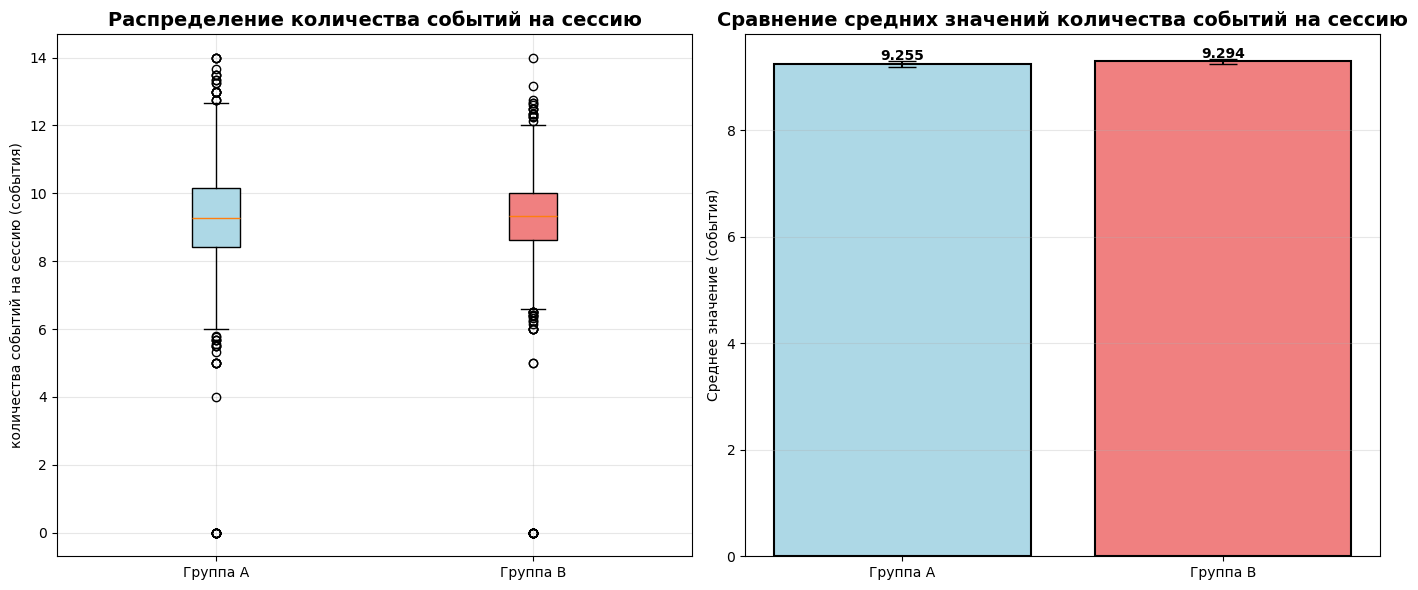


Доверительные интервалы (95%):
  Группа A: 9.20 - 9.31 (среднее: 9.25)
  Группа B: 9.24 - 9.34 (среднее: 9.29)


In [96]:
# Проверяем нормальность распределения
is_normal = check_normality(group_a['avg_events_per_session'], 
                           group_b['avg_events_per_session'], 
                           'количество событий на сессию')

# Выбираем тест (односторонний, так как гипотеза направленная: B > A)
if is_normal:
    print("\nИспользуем односторонний t-тест (данные распределены нормально)")
    t_stat, p_value = stats.ttest_ind(group_a['avg_events_per_session'], 
                                       group_b['avg_events_per_session'], 
                                       equal_var=False, 
                                       alternative='less')  # Проверяем, что B > A
    test_name = "односторонний t-тест"
else:
    print("\nИспользуем односторонний U-тест Манна-Уитни (данные НЕ распределены нормально)")
    u_stat, p_value = stats.mannwhitneyu(group_a['avg_events_per_session'], 
                                         group_b['avg_events_per_session'], 
                                         alternative='less')  # Проверяем, что B > A
    test_name = "односторонний U-тест Манна-Уитни"

print(f"\n{test_name}:")
print(f"  Статистика: {t_stat if is_normal else u_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
p_value_h3 = p_value

# Определяем статистическую значимость
if p_value < alpha:
    print(f"  РЕЗУЛЬТАТ: p-value ({p_value:.4f}) < {alpha} => Различие СТАТИСТИЧЕСКИ ЗНАЧИМО")
    print(f"  ВЫВОД: Количество событий на сессию в группе B статистически значимо БОЛЬШЕ, чем в группе A")
else:
    print(f"  РЕЗУЛЬТАТ: p-value ({p_value:.4f}) ≥ {alpha} => Различие НЕ статистически значимо")
    print(f"  ВЫВОД: Нет достаточных доказательств, что количество событий на сессию в группе B больше")

# Визуализация
mean_a, mean_b, ci_a, ci_b = plot_comparison(
    group_a['avg_events_per_session'], 
    group_b['avg_events_per_session'], 
    'количества событий на сессию', 
    unit='события', 
    show_distribution=True
)

print(f"\nДоверительные интервалы (95%):")
print(f"  Группа A: {ci_a[0]:.2f} - {ci_a[1]:.2f} (среднее: {mean_a:.2f})")
print(f"  Группа B: {ci_b[0]:.2f} - {ci_b[1]:.2f} (среднее: {mean_b:.2f})")

ГИПОТЕЗА 4: Время, проведенное в приложении (длина сессии), в группе B БОЛЬШЕ, чем в группе A


Проверка нормальности для 'длительность сессии':
  Группа A: p-value = 0.0000 (не нормальное)
  Группа B: p-value = 0.0000 (не нормальное)

Используем односторонний U-тест Манна-Уитни (данные НЕ распределены нормально)

односторонний U-тест Манна-Уитни:
  Статистика: 680982.0000
  p-value: 0.0000
  РЕЗУЛЬТАТ: p-value (0.0000) < 0.05 → Различие СТАТИСТИЧЕСКИ ЗНАЧИМО
  ВЫВОД: Длительность сессии в группе B статистически значимо БОЛЬШЕ, чем в группе A


C:\Users\Home\AppData\Local\Temp\ipykernel_9264\1946085054.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(data_to_plot, labels=['Группа A', 'Группа B'],


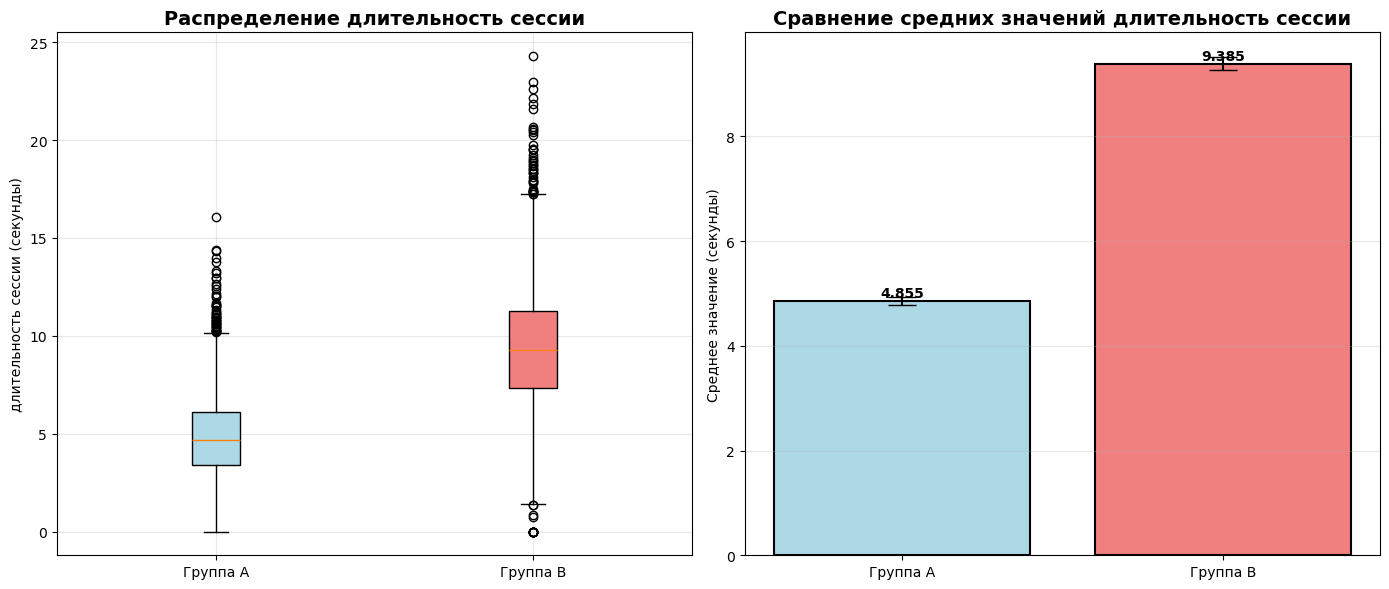


Доверительные интервалы (95%):
  Группа A: 4.8 - 4.9 сек (среднее: 4.9 сек = 0.1 мин)
  Группа B: 9.3 - 9.5 сек (среднее: 9.4 сек = 0.2 мин)


In [97]:
# Проверяем нормальность распределения
is_normal = check_normality(group_a['avg_session_duration_min'], 
                           group_b['avg_session_duration_min'], 
                           'длительность сессии')

# Выбираем тест (односторонний, так как гипотеза направленная: B > A)
if is_normal:
    print("\nИспользуем односторонний t-тест (данные распределены нормально)")
    t_stat, p_value = stats.ttest_ind(group_a['avg_session_duration_min'], 
                                       group_b['avg_session_duration_min'], 
                                       equal_var=False, 
                                       alternative='less')  # Проверяем, что B > A
    test_name = "односторонний t-тест"
else:
    print("\nИспользуем односторонний U-тест Манна-Уитни (данные НЕ распределены нормально)")
    u_stat, p_value = stats.mannwhitneyu(group_a['avg_session_duration_min'], 
                                         group_b['avg_session_duration_min'], 
                                         alternative='less')  # Проверяем, что B > A
    test_name = "односторонний U-тест Манна-Уитни"

print(f"\n{test_name}:")
print(f"  Статистика: {t_stat if is_normal else u_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
p_value_h4 = p_value

# Определяем статистическую значимость
if p_value < alpha:
    print(f"  РЕЗУЛЬТАТ: p-value ({p_value:.4f}) < {alpha} => Различие СТАТИСТИЧЕСКИ ЗНАЧИМО")
    print(f"  ВЫВОД: Длительность сессии в группе B статистически значимо БОЛЬШЕ, чем в группе A")
else:
    print(f"  РЕЗУЛЬТАТ: p-value ({p_value:.4f}) ≥ {alpha} => Различие НЕ статистически значимо")
    print(f"  ВЫВОД: Нет достаточных доказательств, что длительность сессии в группе B больше")

# Визуализация
mean_a, mean_b, ci_a, ci_b = plot_comparison(
    group_a['avg_session_duration_min'], 
    group_b['avg_session_duration_min'], 
    'длительность сессии', 
    unit='секунды', 
    show_distribution=True
)

# Конвертация в минуты для интерпретации
print(f"\nДоверительные интервалы (95%):")
print(f"  Группа A: {ci_a[0]:.1f} - {ci_a[1]:.1f} сек (среднее: {mean_a:.1f} сек = {mean_a/60:.1f} мин)")
print(f"  Группа B: {ci_b[0]:.1f} - {ci_b[1]:.1f} сек (среднее: {mean_b:.1f} сек = {mean_b/60:.1f} мин)")

ИТОГОВАЯ СВОДКА

In [99]:
results_summary = pd.DataFrame({
    'Метрика': ['Конверсия в транзакцию', 
                'Количество сессий на пользователя', 
                'Среднее событий на сессию', 
                'Средняя длительность сессии'],
    'Группа A (среднее)': [
        f"{success_a/n_a*100:.1f}%",
        f"{group_a['sessions_count'].mean():.2f}",
        f"{group_a['avg_events_per_session'].mean():.2f}",
        f"{group_a['avg_session_duration_min'].mean():.2f} мин"
    ],
    'Группа B (среднее)': [
        f"{success_b/n_b*100:.1f}%",
        f"{group_b['sessions_count'].mean():.2f}",
        f"{group_b['avg_events_per_session'].mean():.2f}",
        f"{group_b['avg_session_duration_min'].mean():.2f} мин"
    ],
    'Изменение (%)': [
        f"{(success_b/n_b)/(success_a/n_a)*100 - 100:+.1f}%",
        f"{(group_b['sessions_count'].mean()/group_a['sessions_count'].mean() - 1)*100:+.1f}%",
        f"{(group_b['avg_events_per_session'].mean()/group_a['avg_events_per_session'].mean() - 1)*100:+.1f}%",
        f"{(group_b['avg_session_duration_min'].mean()/group_a['avg_session_duration_min'].mean() - 1)*100:+.1f}%"
    ],
    'p-value': [f"{p_value_h1:.4f}", f"{p_value_h2:.4f}", f"{p_value_h3:.4f}", f"{p_value_h4:.4f}"],
    'Стат. значимость': [
        '✓' if p_value_h1 < alpha else '✗',
        '✓' if p_value_h2 < alpha else '✗',
        '✓' if p_value_h3 < alpha else '✗',
        '✓' if p_value_h4 < alpha else '✗'
    ]
})

print("\n" + results_summary.to_string(index=False))
print(f"\nУровень значимости (alpha): {alpha}")
print("✓ - статистически значимое различие (p < 0.05)")
print("✗ - различие не статистически значимо")

# Сохранение результатов
results_summary.to_csv('ab_test_results_summary.csv', index=False, encoding='utf-8')
print("\nРезультаты сохранены в 'ab_test_results_summary.csv'")


                          Метрика Группа A (среднее) Группа B (среднее) Изменение (%) p-value Стат. значимость
           Конверсия в транзакцию              75.4%              76.2%         +1.2%  0.2362                ✗
Количество сессий на пользователя               6.02               7.94        +31.9%  0.0000                ✓
        Среднее событий на сессию               9.25               9.29         +0.4%  0.0552                ✗
      Средняя длительность сессии           4.86 мин           9.38 мин        +93.3%  0.0000                ✓

Уровень значимости (alpha): 0.05
✓ - статистически значимое различие (p < 0.05)
✗ - различие не статистически значимо

Результаты сохранены в 'ab_test_results_summary.csv'


РЕГРЕССИОННОЕ МОДЕЛИРОВАНИЕ

Данные за период: 2025-05-21 - 2025-11-17
Средняя посещаемость: 11554 посещений/день

Linear Regression:
MAE:  1213 посещений
MAPE: 10.7%
RMSE: 1798 посещений

Random Forest:
MAE:  951 посещений
MAPE: 8.1%
RMSE: 1433 посещений


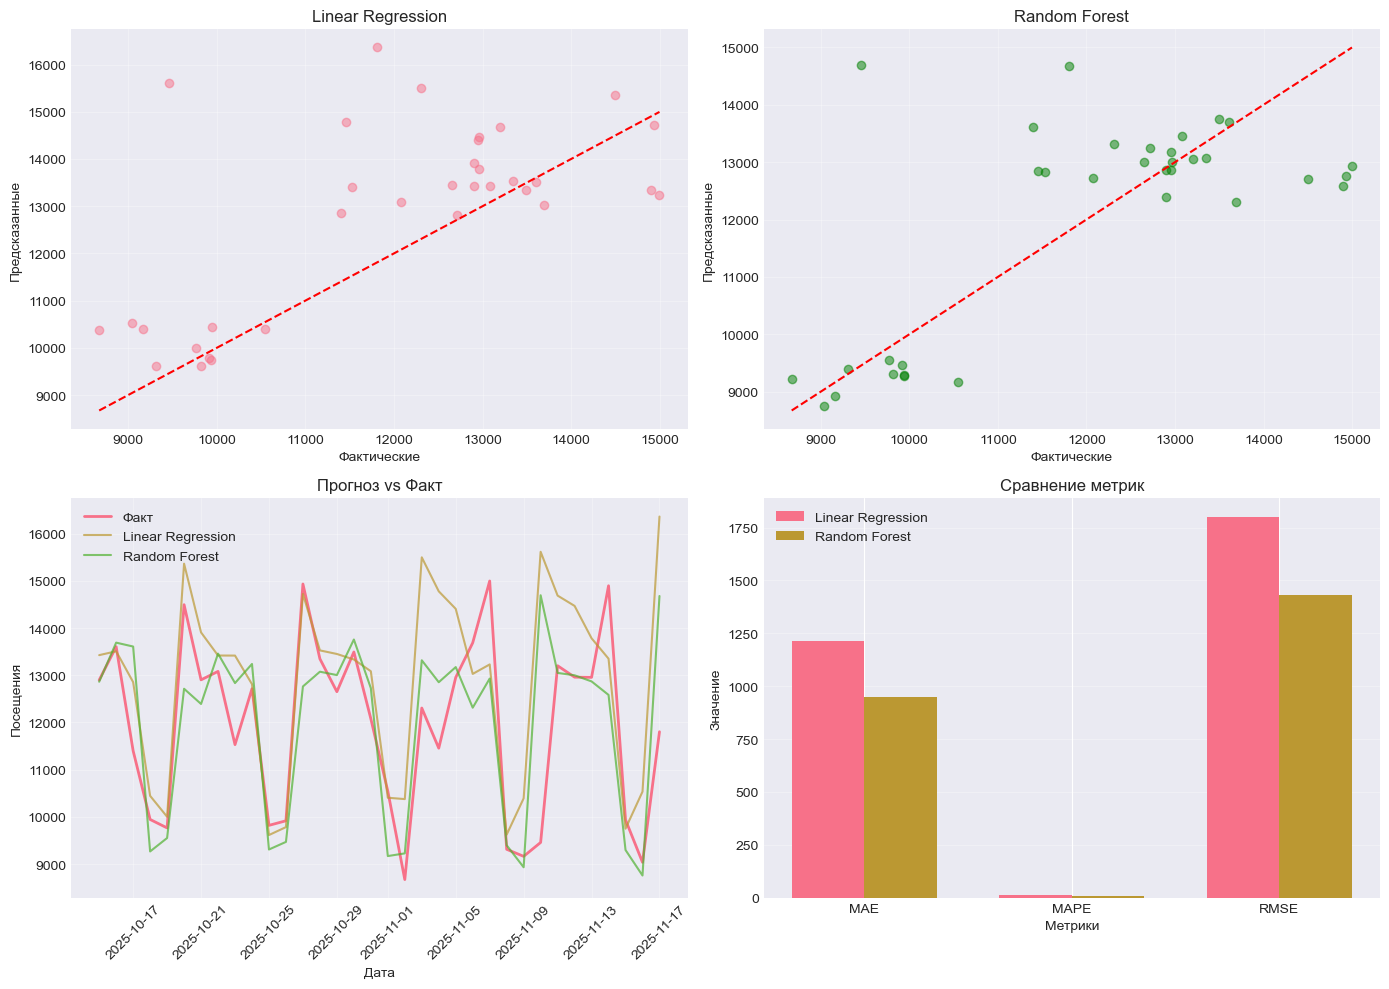


Топ-5 важных признаков:
       feature  importance
         lag_1    0.194786
    is_weekend    0.181248
   day_of_week    0.162399
rolling_mean_7    0.136072
         lag_7    0.095294

ЛУЧШАЯ МОДЕЛЬ: Random Forest
MAPE: 8.1%
Интерпретация: модель ошибается в среднем на 951 посещений
Это составляет 8.1% от фактических значений

Результаты сохранены в model_metrics.csv и feature_importance.csv


In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

visits = visits.sort_values('event_date').reset_index(drop=True)
print(f"Данные за период: {visits['event_date'].min().date()} - {visits['event_date'].max().date()}")
print(f"Средняя посещаемость: {visits['visits'].mean():.0f} посещений/день")

# Создание признаков
df = visits.copy()

# Временные признаки
df['day_of_week'] = df['event_date'].dt.dayofweek  # 0-понедельник
df['month'] = df['event_date'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Лаговые признаки
for lag in [1, 2, 7, 14]:
    df[f'lag_{lag}'] = df['visits'].shift(lag)

# Скользящие средние
for window in [7, 14]:
    df[f'rolling_mean_{window}'] = df['visits'].shift(1).rolling(window=window).mean()

# Удаляем строки с пропусками
df_clean = df.dropna().reset_index(drop=True)

# Разделяем на признаки и целевую переменную
X = df_clean.drop(['event_date', 'visits'], axis=1)
y = df_clean['visits']

# Разделение по времени (не случайное!)
split_idx = int(len(df_clean) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение моделей
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'mae': mean_absolute_error(y_test, y_pred),
        'mape': mean_absolute_percentage_error(y_test, y_pred) * 100,
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
    }
    
    print(f"\n{name}:")
    print(f"MAE:  {results[name]['mae']:.0f} посещений")
    print(f"MAPE: {results[name]['mape']:.1f}%")
    print(f"RMSE: {results[name]['rmse']:.0f} посещений")

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Linear Regression
axes[0,0].scatter(y_test, results['Linear Regression']['y_pred'], alpha=0.5)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,0].set_xlabel('Фактические')
axes[0,0].set_ylabel('Предсказанные')
axes[0,0].set_title('Linear Regression')
axes[0,0].grid(True, alpha=0.3)

# Random Forest
axes[0,1].scatter(y_test, results['Random Forest']['y_pred'], alpha=0.5, color='green')
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,1].set_xlabel('Фактические')
axes[0,1].set_ylabel('Предсказанные')
axes[0,1].set_title('Random Forest')
axes[0,1].grid(True, alpha=0.3)

# Временной ряд с прогнозами
dates_test = df_clean.iloc[split_idx:]['event_date']
axes[1,0].plot(dates_test, y_test, label='Факт', linewidth=2)
axes[1,0].plot(dates_test, results['Linear Regression']['y_pred'], label='Linear Regression', alpha=0.7)
axes[1,0].plot(dates_test, results['Random Forest']['y_pred'], label='Random Forest', alpha=0.7)
axes[1,0].set_xlabel('Дата')
axes[1,0].set_ylabel('Посещения')
axes[1,0].set_title('Прогноз vs Факт')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=45)

# Сравнение метрик
metrics = ['MAE', 'MAPE', 'RMSE']
lr_vals = [results['Linear Regression']['mae'], results['Linear Regression']['mape'], results['Linear Regression']['rmse']]
rf_vals = [results['Random Forest']['mae'], results['Random Forest']['mape'], results['Random Forest']['rmse']]

x = np.arange(len(metrics))
width = 0.35
axes[1,1].bar(x - width/2, lr_vals, width, label='Linear Regression')
axes[1,1].bar(x + width/2, rf_vals, width, label='Random Forest')
axes[1,1].set_xlabel('Метрики')
axes[1,1].set_ylabel('Значение')
axes[1,1].set_title('Сравнение метрик')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(metrics)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Анализ важности признаков для Random Forest
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-5 важных признаков:")
print(feature_importance.head(5).to_string(index=False))

# Выбор лучшей модели
best_model_name = min(results.items(), key=lambda x: x[1]['mape'])[0]
best_metrics = results[best_model_name]

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"MAPE: {best_metrics['mape']:.1f}%")
print(f"Интерпретация: модель ошибается в среднем на {best_metrics['mae']:.0f} посещений")
print(f"Это составляет {best_metrics['mape']:.1f}% от фактических значений")

# Сохранение результатов
pd.DataFrame([
    {'model': name, 'mae': m['mae'], 'mape': m['mape'], 'rmse': m['rmse']}
    for name, m in results.items()
]).to_csv('model_metrics.csv', index=False)

feature_importance.to_csv('feature_importance.csv', index=False)

print("\nРезультаты сохранены в model_metrics.csv и feature_importance.csv")